In [1]:
"""
This script extracts [CLS] embeddings from clinical transcripts using BioBERT.
Saves 768-d embeddings (with time info if present) for each user separately.
"""

import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, logging
from tqdm import tqdm
import warnings
import gc

# Suppress logs and warnings
logging.set_verbosity_error()
warnings.filterwarnings("ignore")

RAW_DATA_PATH = '../../data/raw'
SAVE_BASE_PATH = '../../data/interim/clinical_features'
BATCH_SIZE = 8
MAX_LENGTH = 512

# Choose BioBERT variant from Hugging Face
BIoBERT_MODEL = 'dmis-lab/biobert-base-cased-v1.1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🧠 Using device: {device}")

print("🔬 Loading BioBERT model...")
tokenizer = AutoTokenizer.from_pretrained(BIoBERT_MODEL)
model = AutoModel.from_pretrained(BIoBERT_MODEL)
model.to(device)
model.eval()

def get_biobert_embeddings(texts, batch_size=BATCH_SIZE):
    if not texts:
        return np.array([]).reshape(0, 768)
    
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="🔄 Extracting batches"):
        batch = texts[i:i + batch_size]
        batch = [text if text and text.strip() else "[EMPTY]" for text in batch]
        
        try:
            inputs = tokenizer(
                batch, 
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=MAX_LENGTH
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
                cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(cls_embeddings)
            
            del inputs, outputs
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            gc.collect()
            
        except Exception as e:
            print(f"⚠️ Batch {i//batch_size + 1} failed: {e}")
            zero_embeddings = np.zeros((len(batch), 768))
            embeddings.append(zero_embeddings)
    
    return np.vstack(embeddings)

def process_user_clinical(user_path, save_dir, user_name):
    transcript_file = next(
        (f for f in os.listdir(user_path) if f.endswith('_Transcript.csv')), 
        None
    )
    
    if transcript_file is None:
        print(f"⚠️ No clinical transcript found for {user_name}")
        return False

    csv_path = os.path.join(user_path, transcript_file)
    
    try:
        file_size_mb = os.path.getsize(csv_path) / (1024 * 1024)
        print(f"\n🩺 Processing {user_name} ({file_size_mb:.1f}MB)")
        
        df = pd.read_csv(csv_path)
        
        if 'Text' not in df.columns:
            print(f"⚠️ 'Text' column missing in {user_name}'s file")
            return False
        
        texts = df['Text'].fillna('').astype(str).tolist()
        
        if not texts:
            print(f"⚠️ No clinical text for {user_name}")
            return False
        
        features = get_biobert_embeddings(texts)
        if features.size == 0:
            print(f"⚠️ No embeddings for {user_name}")
            return False
        
        df_features = pd.DataFrame(features, columns=[f'biobert_{i}' for i in range(768)])
        
        if 'Start_Time' in df.columns:
            df_features['Start_Time'] = df['Start_Time'].reset_index(drop=True)
        if 'End_Time' in df.columns:
            df_features['End_Time'] = df['End_Time'].reset_index(drop=True)
        
        os.makedirs(save_dir, exist_ok=True)
        output_path = os.path.join(save_dir, 'clinical_features.parquet')
        df_features.to_parquet(output_path, index=False)
        
        print(f"✅ Saved clinical features for {user_name} ({features.shape[0]} samples)")
        return True

    except Exception as e:
        print(f"❌ Error processing {user_name}: {e}")
        return False

def main():
    if not os.path.exists(RAW_DATA_PATH):
        print(f"❌ Raw data path does not exist: {RAW_DATA_PATH}")
        return
    
    users = [u for u in os.listdir(RAW_DATA_PATH) 
             if os.path.isdir(os.path.join(RAW_DATA_PATH, u))]
    
    if not users:
        print("❌ No user directories found")
        return
    
    print(f"👥 Found {len(users)} users to process")
    success, failure = 0, 0
    
    for user in users:
        user_path = os.path.join(RAW_DATA_PATH, user, 'clinical')
        if not os.path.isdir(user_path):
            print(f"⚠️ Clinical directory not found for {user}")
            failure += 1
            continue
        
        save_dir = os.path.join(SAVE_BASE_PATH, user)
        if process_user_clinical(user_path, save_dir, user):
            success += 1
        else:
            failure += 1
    
    print(f"\n📊 Clinical Feature Extraction Summary:")
    print(f"✅ Successful: {success}")
    print(f"❌ Failed: {failure}")
    print(f"📁 Total: {len(users)}")

if __name__ == "__main__":
    main()


/opt/anaconda3/envs/depression-nlp-fyp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧠 Using device: cpu
🔬 Loading BioBERT model...
👥 Found 3 users to process

🩺 Processing 302_P (0.0MB)


🔄 Extracting batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.17it/s]


✅ Saved clinical features for 302_P (99 samples)

🩺 Processing 301_P (0.0MB)


🔄 Extracting batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.26it/s]


✅ Saved clinical features for 301_P (72 samples)
⚠️ No clinical transcript found for .ipynb_checkpoints

📊 Clinical Feature Extraction Summary:
✅ Successful: 2
❌ Failed: 1
📁 Total: 3


📥 Loading all clinical features per user...
🎯 Applying PCA and saving features...
User: 302_P - Selected components: 59, Explained variance: 95.12%


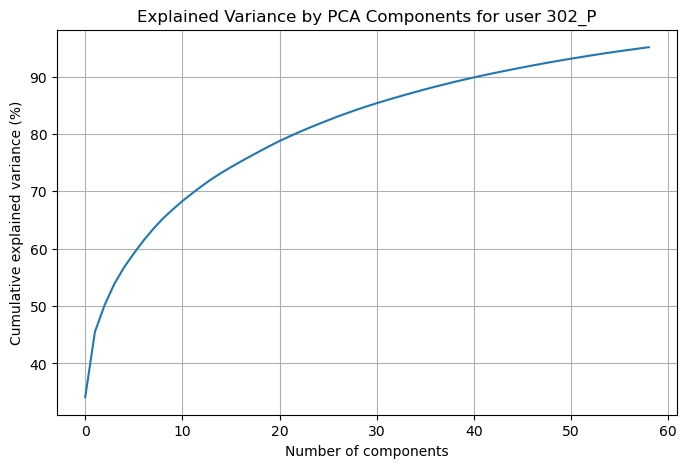

✅ Saved PCA features for user 302_P at ../../data/interim/clinical_features/302_P/pca_clinical_features.parquet
User: 301_P - Selected components: 40, Explained variance: 95.17%


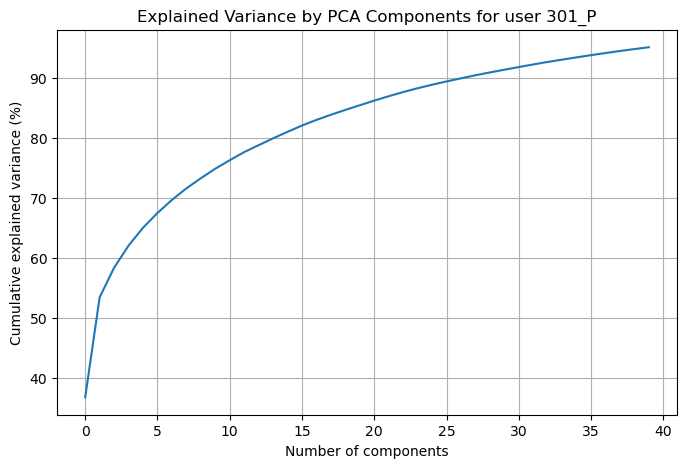

✅ Saved PCA features for user 301_P at ../../data/interim/clinical_features/301_P/pca_clinical_features.parquet


In [4]:
"""
This script processes clinical features for multiple users by:
1. Loading user-wise clinical feature files (.parquet) from a specified directory.
2. Applying PCA to reduce dimensionality while retaining 95% of variance.
3. Renaming reduced features to clinical_f1, clinical_f2, ..., and keeping time columns (if available).
4. Plotting explained variance for each user.
5. Saving the final PCA-transformed features (with time) back to disk for each user.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

SAVE_BASE_PATH = '../../data/interim/clinical_features'

def load_features_per_user(base_path):
    """Load clinical features for each user separately, keeping time columns."""
    user_features = {}
    for user in os.listdir(base_path):
        user_dir = os.path.join(base_path, user)
        if os.path.isdir(user_dir):
            user_path = os.path.join(user_dir, 'clinical_features.parquet')  # changed
            if os.path.isfile(user_path):
                df = pd.read_parquet(user_path)
                feature_cols = [col for col in df.columns if col.startswith('biobert_')]  # changed
                
                # Collect both features and any time columns
                time_cols = [col for col in ['Start_Time', 'End_Time'] if col in df.columns]
                user_features[user] = {
                    'features': df[feature_cols],
                    'time_info': df[time_cols] if time_cols else None
                }
            else:
                print(f"⚠️ No features file for user {user}")
    return user_features

def plot_explained_variance(pca, user):
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance (%)')
    plt.title(f'Explained Variance by PCA Components for user {user}')
    plt.grid(True)
    plt.show()

def save_pca_per_user(user_features):
    for user, data in user_features.items():
        features_np = data['features'].values
        time_info = data['time_info']
        
        pca = PCA(n_components=0.95)
        pca_result = pca.fit_transform(features_np)
        
        print(f"User: {user} - Selected components: {pca.n_components_}, Explained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")
        
        plot_explained_variance(pca, user)
        
        pca_df = pd.DataFrame(
            pca_result,
            columns=[f'clinical_f{i+1}' for i in range(pca_result.shape[1])]  # changed
        )
        
        if time_info is not None:
            pca_df = pd.concat([pca_df, time_info.reset_index(drop=True)], axis=1)
        
        save_path = os.path.join(SAVE_BASE_PATH, user, 'pca_clinical_features.parquet')  # changed
        pca_df.to_parquet(save_path, index=False)
        print(f"✅ Saved PCA features for user {user} at {save_path}")

def main():
    print("📥 Loading all clinical features per user...")
    user_features = load_features_per_user(SAVE_BASE_PATH)
    
    print("🎯 Applying PCA and saving features...")
    save_pca_per_user(user_features)

if __name__ == "__main__":
    main()
